# ДЗ 2. «Элементарные методы анализа временных рядов»

### Задание  

1. Возьмите из прошлого домашнего задания ряд — стационарный и не стационарный.  
2. Приблизьте оба варианта моделями из класса MA.  
3. Оцените качество и пришлите соображения, почему была выбрана та или иная модель  

In [1]:
import os

import pandas as pd
import numpy as np

from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [3]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

### Загружаю ряды из прошлого домашнего задания

In [4]:
folder = 'D:/Git_repos/time_series/data/Series'
file_names = os.listdir(folder)

paths = []

for i, filename in enumerate(file_names):
    fullpath = os.path.join(folder, filename)
    paths.append(fullpath)
paths

['D:/Git_repos/time_series/data/Series\\daily-total-female-births-in-cal.csv',
 'D:/Git_repos/time_series/data/Series\\international-airline-passengers.csv',
 'D:/Git_repos/time_series/data/Series\\mean-monthly-air-temperature-deg.csv',
 'D:/Git_repos/time_series/data/Series\\monthly-boston-armed-robberies-j.csv',
 'D:/Git_repos/time_series/data/Series\\monthly-sales-of-company-x-jan-6.csv',
 'D:/Git_repos/time_series/data/Series\\weekly-closings-of-the-dowjones-.csv']

In [5]:
sales_of_company_x = pd.read_csv(paths[4])
robberies_in_boston = pd.read_csv(paths[3])
airlines_passengers = pd.read_csv(paths[1])
mean_monthly_temp = pd.read_csv(paths[2])
dowjones_closing = pd.read_csv(paths[5])
female_births = pd.read_csv(paths[0])

In [6]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

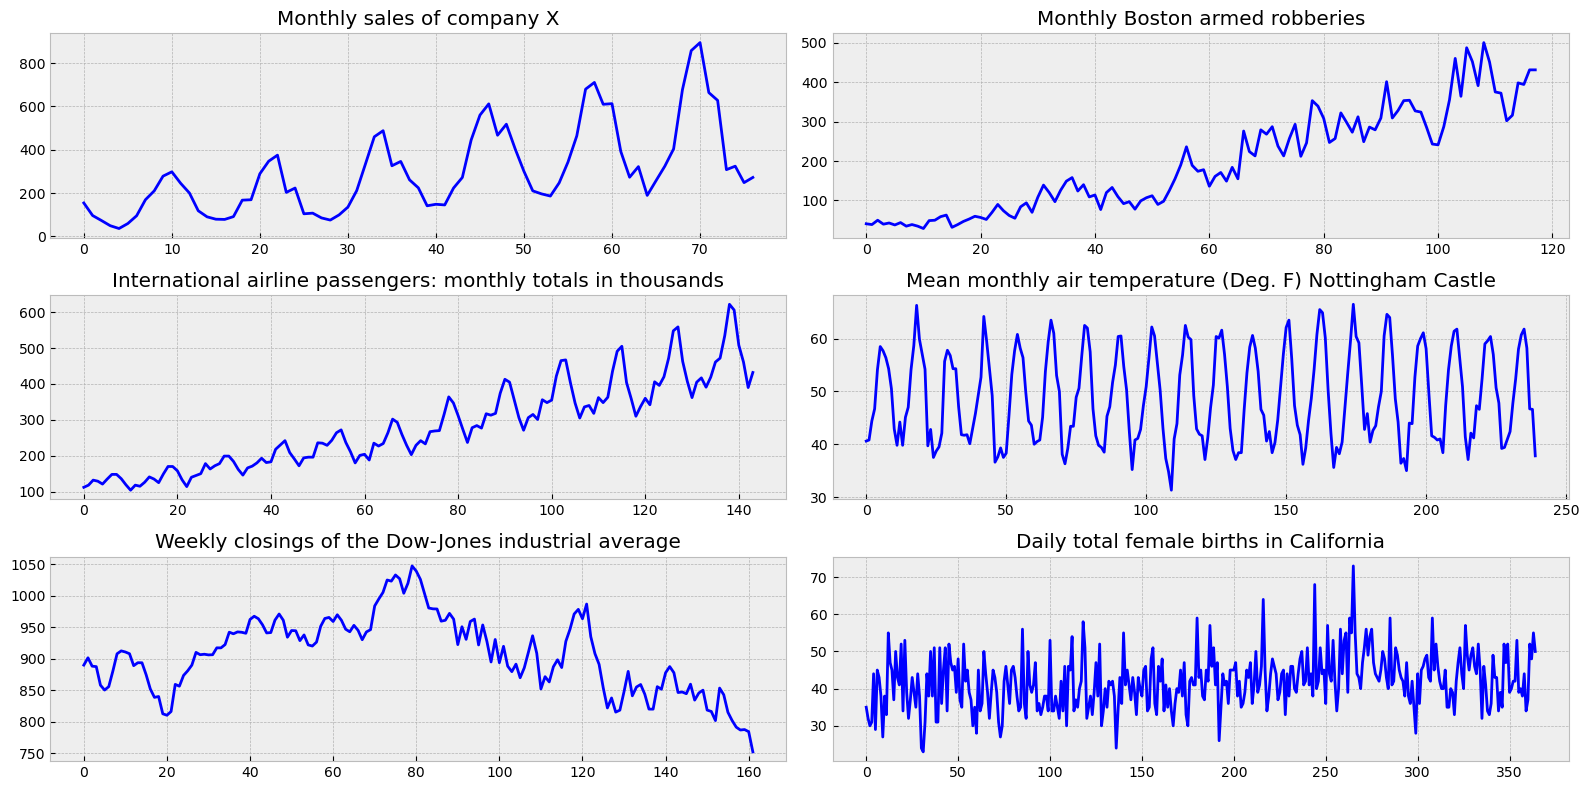

In [7]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

По результатам ДЗ №1 выбираю два ряда:
    
ряд "Daily total female births in California"  - как стационарный, что показал первичный тест Дики_Фуллера.

ряд "International airline passengers: monthly totals in thousands" - как не стационарный,содержащий тренд и сезонность. 

In [11]:
female_births["Count"][:3], len(female_births["Count"])

(0    35
 1    32
 2    30
 Name: Count, dtype: int64,
 365)

In [12]:
airlines_passengers["Count"][:3], len(airlines_passengers["Count"])

(0    112
 1    118
 2    132
 Name: Count, dtype: int64,
 144)

**Ряд "Daily total female births in California"**  
стационарный,  
тренд - нет общего для всей протяжённости выборки,  
сезонность - нет.

**Применяю к ряду экспоненциальное сглаживание коэффициентом 0.8**

In [13]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [14]:
series = female_births["Count"]

In [15]:
ema = exponential_moving_average(series, 0.8)

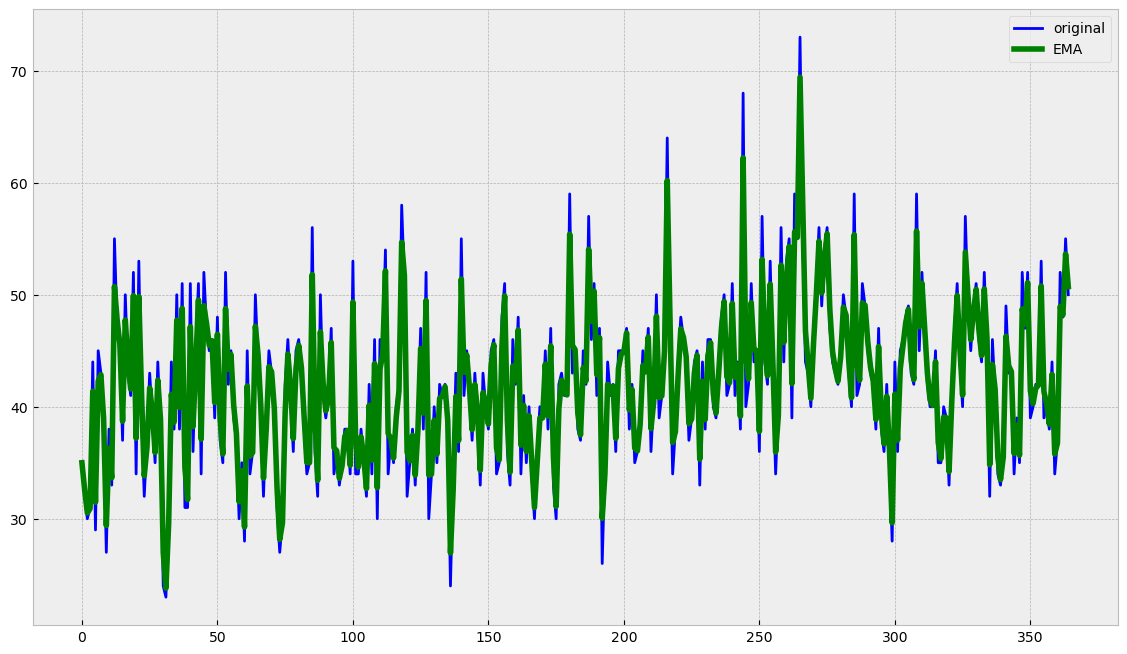

In [16]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    
    plt.plot(ema, color='green', linewidth='4', label='EMA')
    plt.legend()

Для оценки качества предсказания использую mse.

In [18]:
error = mean_squared_error(ema, series)
error

2.84779326389485

In [27]:
alphas = [0.05, 0.1, 0.3, 0.8, 0.9, 1.0]
for i in range(len(alphas)):
    ema = exponential_moving_average(series, alphas[i])
    error = mean_squared_error(ema, series)
    print(f'alpha = {alphas[i]}, mse = {error}')

alpha = 0.05, mse = 45.22348222605644
alpha = 0.1, mse = 40.67619916133241
alpha = 0.3, mse = 26.21237256846243
alpha = 0.8, mse = 2.84779326389485
alpha = 0.9, mse = 0.769684465913359
alpha = 1.0, mse = 0.0


При приближении коэффициента $\alpha$ к 1, mse тановится равной 0, сглаженный ряд вырождается в исходный, что и следует из формулы экспоненциального сглаживания.  
Этот метод применим к стационарному ряду, как учитывающий только уровень, без влияния трендов и сезонностей.

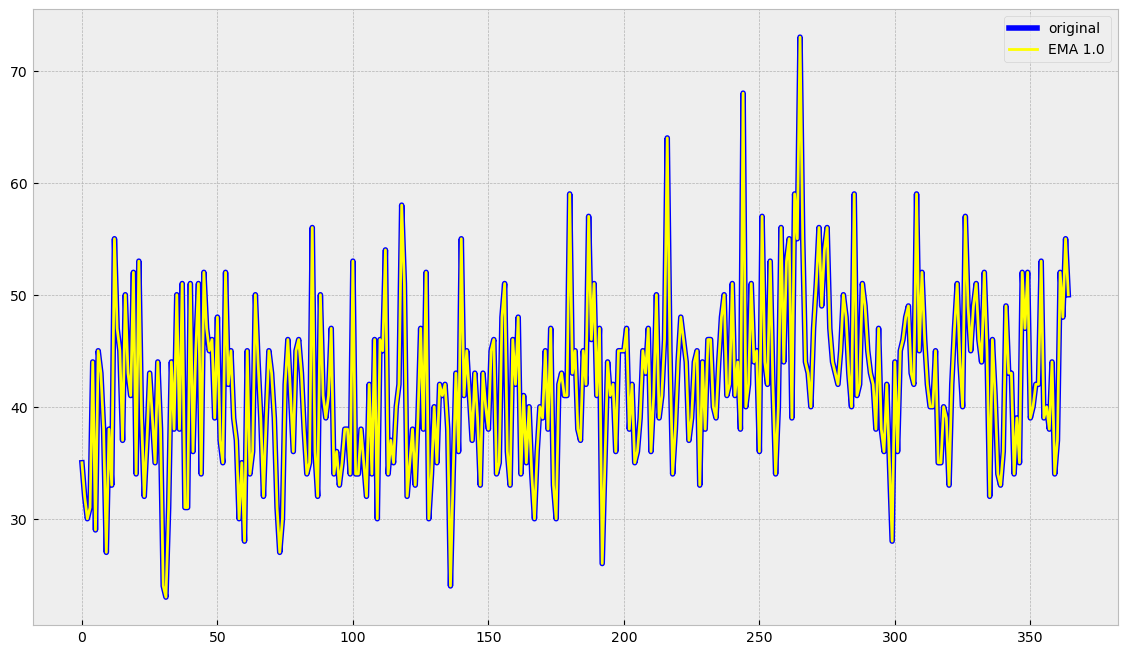

In [26]:
ema = exponential_moving_average(series, 1.0)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue', linewidth='4', label='original')
    
    plt.plot(ema, color='yellow', linewidth='2', label='EMA 1.0')
    plt.legend()

**Ряд "International airline passengers: monthly totals in thousands"**   
не стационарный,  
тренд - есть  
сезонность - есть.

In [56]:
series = airlines_passengers["Count"]

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


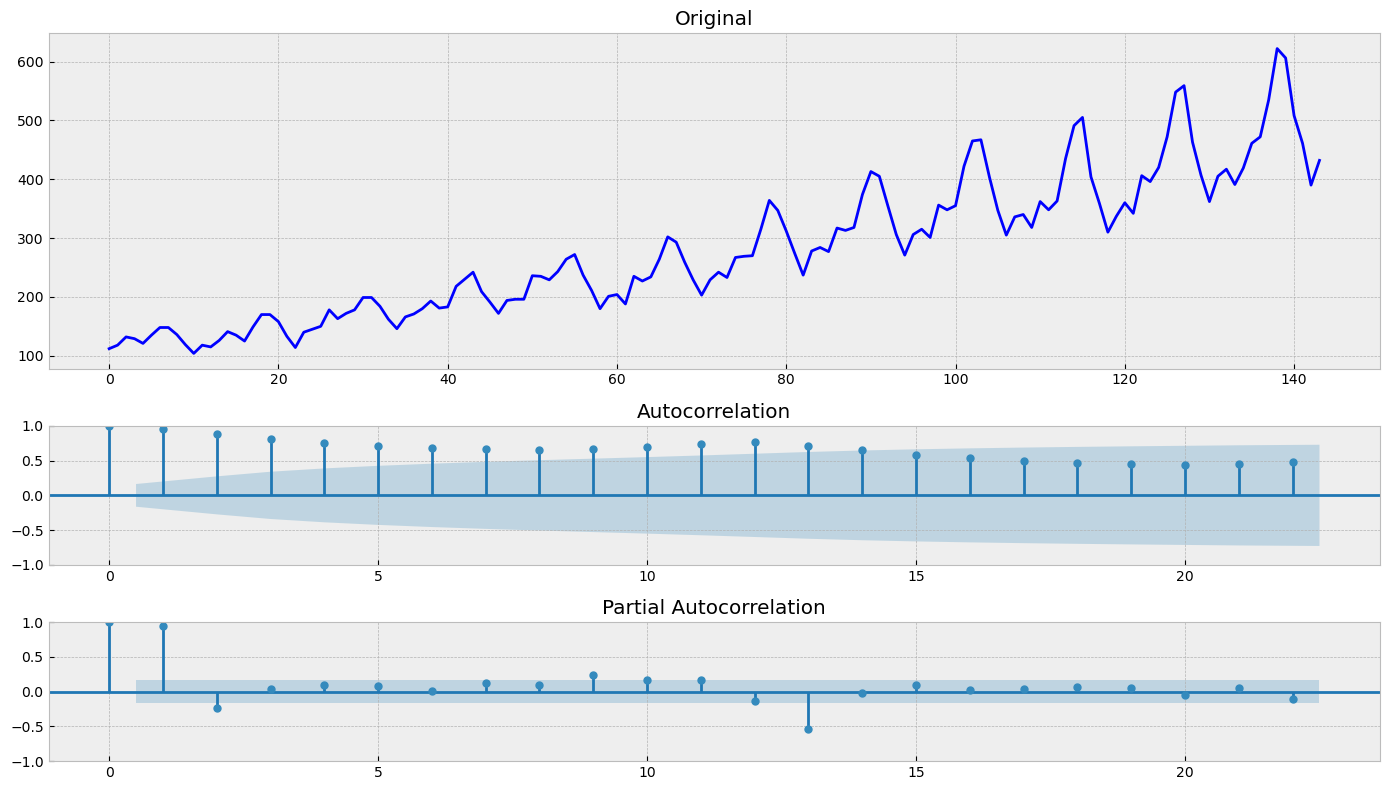

In [29]:
tsplot(series)

**Для сглаживания воспользуюсь методом Хольта-Винтерса.**  


In [57]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [58]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [59]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [60]:
def plot_tema(alpha, beta, gamma, ser=series, ser_to_plot=series, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

 Возьму произвольные коэффициенты $\alpha$ = 0.1,  $\beta$ = 0.1, $\gamma$ = 0.2

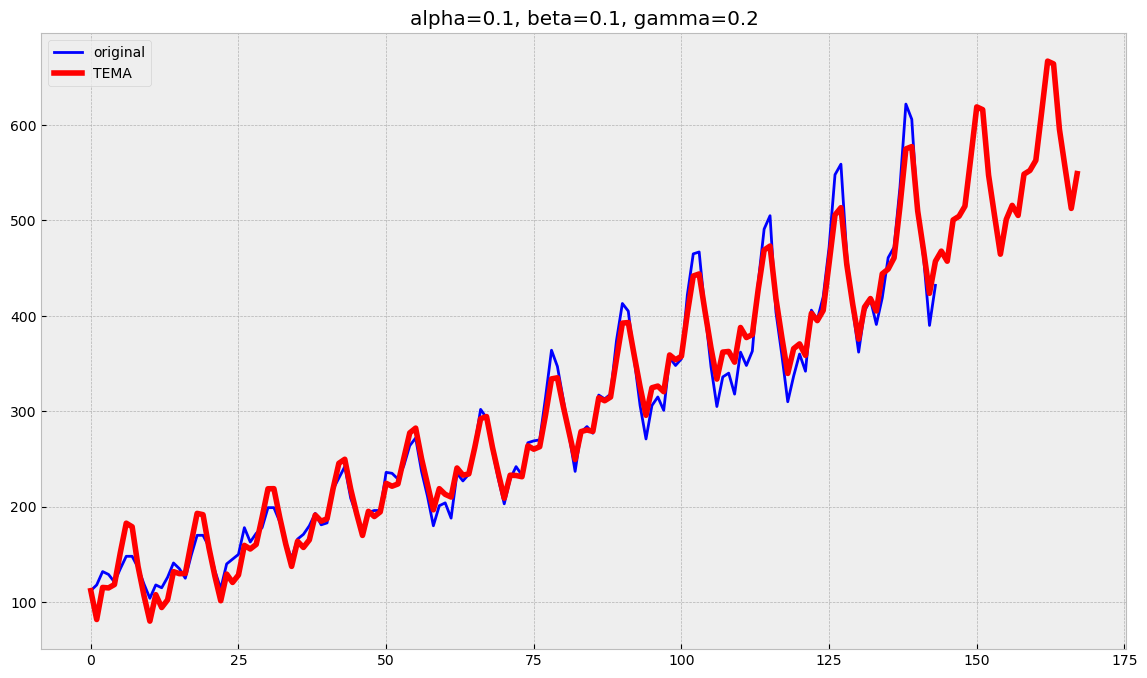

In [35]:
plot_tema(0.1, 0.1, 0.2)

**Подберу параметры**

In [61]:
len(series)

144

In [62]:
train_border = int(len(series)*0.8)
test_border = int(len(series)*0.9)

In [63]:
train, test, val = series[:train_border], series[train_border:test_border], series[test_border:]

In [64]:
len(train), len(test), len(val)

(115, 14, 15)

In [65]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [66]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [67]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 2841.344232253085
        x: [ 1.000e+00  0.000e+00  1.000e+00]
      nit: 1
      jac: [-7.507e+01  3.455e+04 -0.000e+00]
     nfev: 8
     njev: 2
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


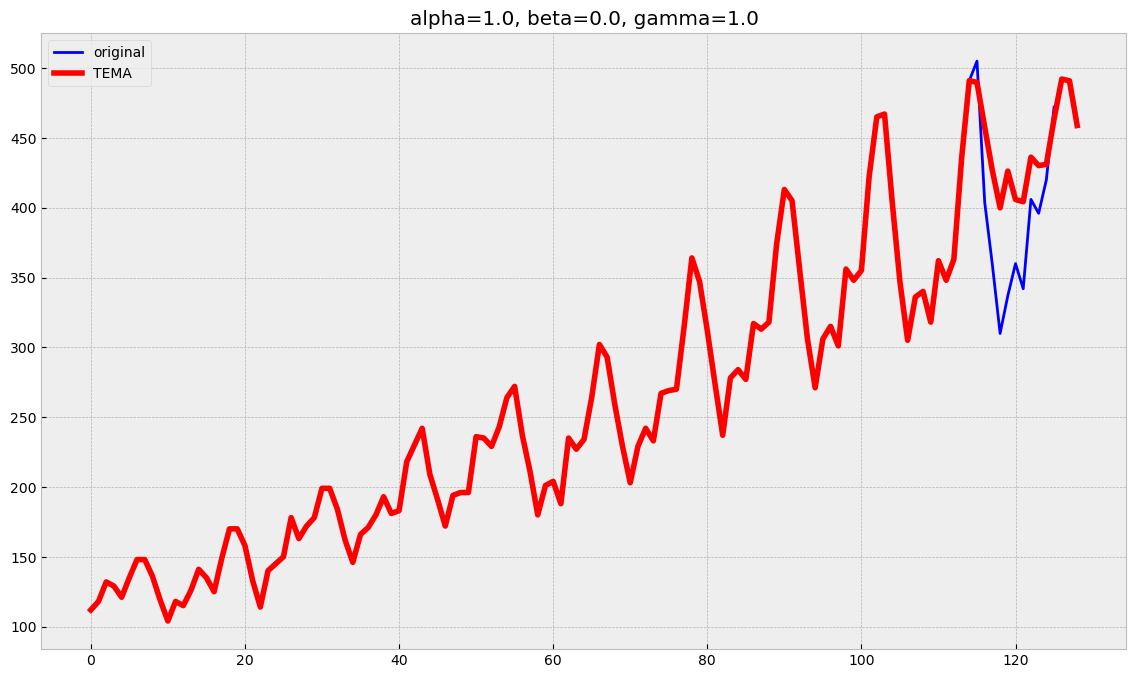

In [68]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series[:126], n_preds=len(test))

**Воспользуюсь кросс-валидацией**

In [78]:
series = airlines_passengers["Count"]

In [79]:
len(series)

144

In [80]:
train_border = int(len(series)*0.8)

In [82]:
train, val = series[:train_border], series[train_border:]

In [83]:
len(train), len(val)

(115, 29)

In [84]:
#from sklearn.model_selection import TimeSeriesSplit

def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
        
        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

Метод Нелдера-Мида

In [85]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="Nelder-Mead") #, bounds = ((0, 1), (0, 1), (0, 1)))
# opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

29498.834698357823------------
29117.116387296293------------
29498.834698357823------------
29467.102679487794------------
29225.191220588236------------
29043.45768172326------------
28821.81629622648------------
28654.820930998027------------
28269.62751284288------------
28247.35724258167------------
27777.02024481745------------
27508.707164161755------------
26786.021457619656------------
26476.798811579178------------
25460.75821002129------------
25177.352155366156------------
23886.60389932535------------
23383.395306397564------------
21856.355384034217------------
21218.246688646526------------
19468.08548021191------------
19003.570719339168------------
17497.9936886707------------
17326.126418611657------------
16961.760324524323------------
16413.185762864672------------
17480.111419173194------------
17797.768430229906------------
16838.591897094335------------
18683.06418196044------------
16702.677577753926------------
16132.863976606806------------
15732.177982628456-

In [86]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 294.14364968206957
             x: [ 1.049e-01  1.043e-01  1.086e+00]
           nit: 149
          nfev: 271
 final_simplex: (array([[ 1.049e-01,  1.043e-01,  1.086e+00],
                       [ 1.050e-01,  1.043e-01,  1.086e+00],
                       [ 1.050e-01,  1.043e-01,  1.086e+00],
                       [ 1.049e-01,  1.043e-01,  1.087e+00]]), array([ 2.941e+02,  2.941e+02,  2.941e+02,  2.941e+02]))


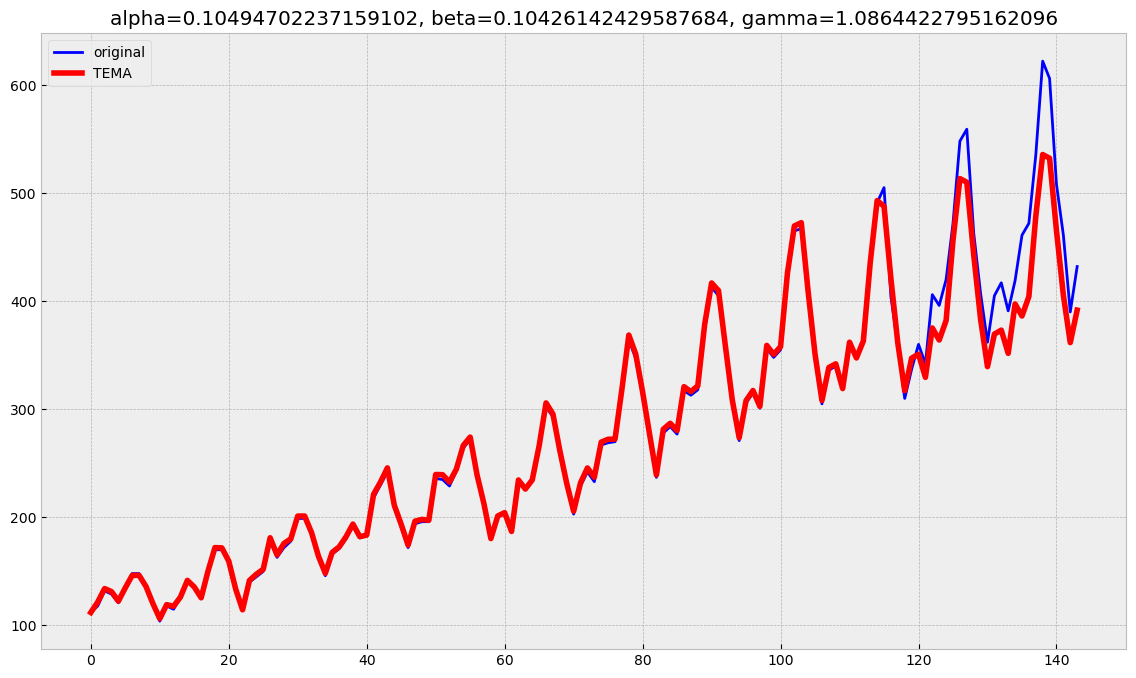

In [87]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(val))

Метод L-BFGS-B

In [88]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

29498.834698357823------------
29498.819279208434------------
29498.834698357892------------
29498.833428184862------------
2953.3913417714975------------
2953.391331988243------------
2953.389512151796------------
2953.3913417714975------------
3744.235336902792------------
3744.235319571306------------
3744.235712902733------------
3744.235336902792------------
1506.2693698995952------------
1506.269357906742------------
1506.2694846419008------------
1506.2693698995952------------
1478.9843477690567------------
1478.9843594279598------------
1478.9844444543835------------
1478.9843477701327------------
1431.664734434388------------
1431.6647443178351------------
1431.664685566845------------
1431.6647344446185------------
1423.8736760590243------------
1423.8736864685131------------
1423.8736864236362------------
1423.8736760679803------------
1422.8476340115842------------
1422.8476442905264------------
1422.8476346902423------------
1422.847634022577------------
1421.7458792530917

In [89]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 295.57462572947856
        x: [ 1.122e-01  9.827e-02  1.000e+00]
      nit: 24
      jac: [-2.314e-03  4.087e-03 -3.132e+01]
     nfev: 140
     njev: 35
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


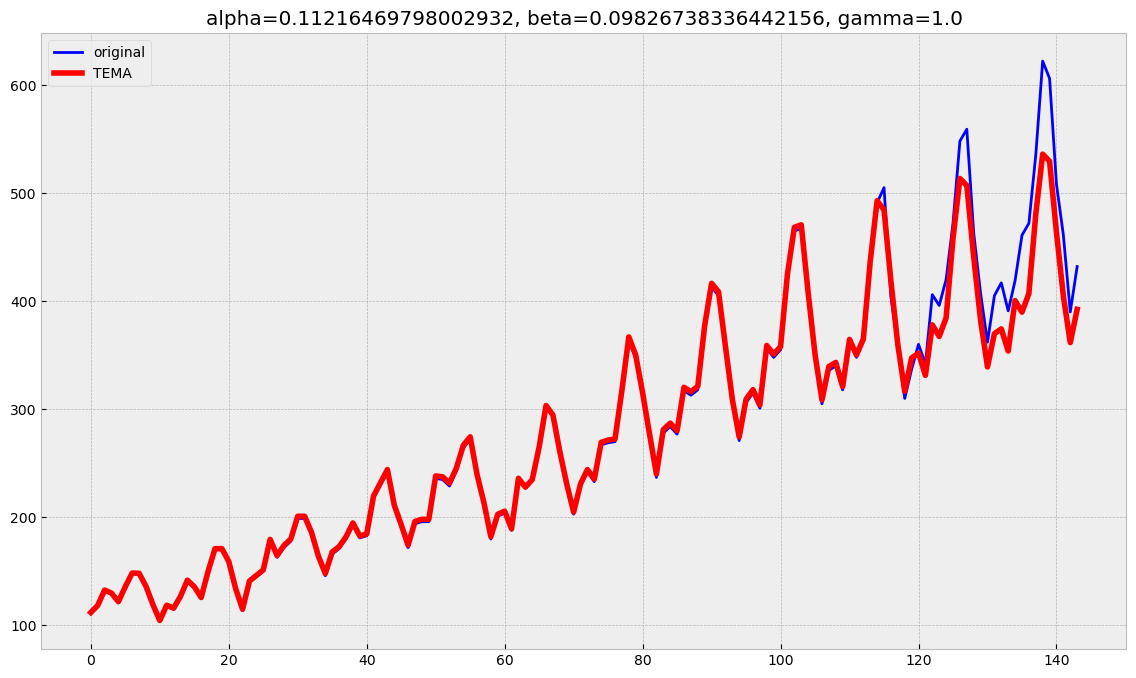

In [90]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(val))

**[Открытый курс машинного обучения. Тема 9. Анализ временных рядов с помощью Python / Хабр](https://habr.com/ru/companies/ods/articles/327242/)**

Метод TNC (Truncated Newton conjugate gradient)

In [91]:
%%time
# data = dataset.Users[:-500] # отложим часть данных для тестирования
train, val = series[:155], series[155:] # отложим часть данных для тестирования

# инициализируем значения параметров
x = [0, 0, 0] 

# Минимизируем функцию потерь с ограничениями на параметры
#opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))
opt = minimize(mse_cross_val, x0=x, method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))
mse_cross_val
# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

50359.357213791496------------
50359.32495733824------------
50359.357213791685------------
50359.354525189534------------
50359.2748757618------------
50359.24261938807------------
50359.274875720825------------
50359.2721871662------------
28770.697360648686------------
28770.684413829633------------
28770.689183946088------------
28770.69623002211------------
9349.840108309894------------
9349.83924554512------------
9349.832854636117------------
9349.840006436663------------
9349.835426773048------------
9349.834564008577------------
9349.828173103846------------
9349.83532489991------------
4601.598533183464------------
4601.598095932001------------
4601.595881364807------------
4601.598509687955------------
1580.8458637102733------------
1580.845922658491------------
1580.8458701177678------------
1580.8458658368706------------
1580.8457058736883------------
1580.8457648218873------------
1580.8457122810826------------
1580.8457080002784------------
2578.1860761869425------------

In [92]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

 message: Max. number of function evaluations reached
 success: False
  status: 3
     fun: 893.8084515091505
       x: [ 4.525e-03  7.392e-01  2.549e-01]
     nit: 23
     jac: [-3.607e+02 -8.267e+01  9.807e+01]
    nfev: 404


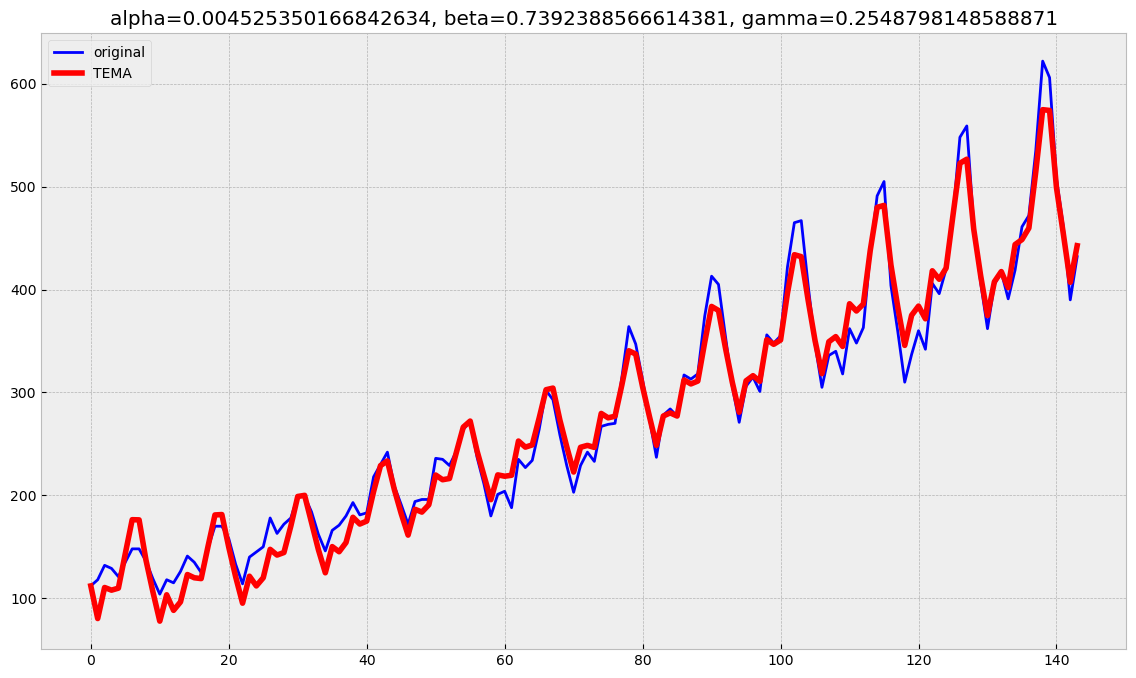

In [93]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(val))

Лучший результат при тройном экспоненциальном сглаживании Хольта-Винтерса получили   
при минимизации ошибки с использованием метода Нелдера-Мида.  
Ряд имеет тренд и сезонность.